Installing necessary libraries

In [ ]:
!pip install spacy
!python3 -m nltk.downloader wordnet
!unzip /root/nltk_data/corpora/wordnet.zip -d /root/nltk_data/corpora/

Import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *

Get the english dataset

In [ ]:
!wget http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
!tar -xf MovieSummaries.tar.gz

Tokenize english dataset with NLTK and visualize

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42303 entries, 0 to 42302
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      42303 non-null  int64 
 1   text    42303 non-null  object
dtypes: int64(1), object(1)
memory usage: 661.1+ KB


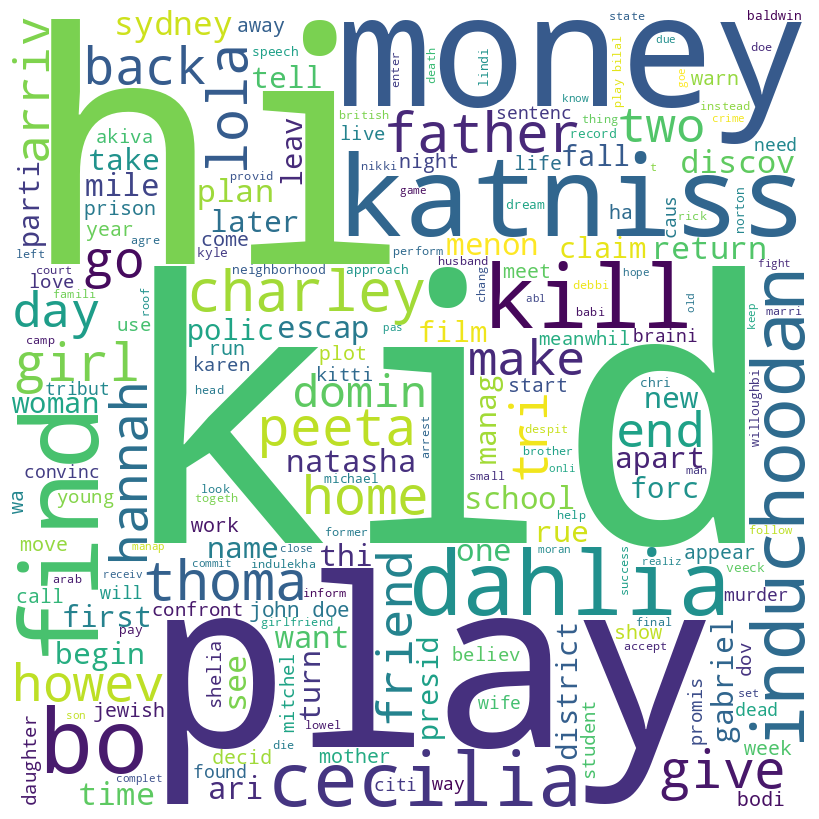

In [4]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

# read as dataframe
df_english = pd.read_csv('/content/MovieSummaries/plot_summaries.txt', delimiter = '\t',names=['id','text'])
df_english.info()
df_english = df_english.head(20)

# normalize and tokenize
token_list_nltk = []
tokenizer = RegexpTokenizer(r'\w+')
for i in range(len(df_english)):
  content = df_english['text'][i]
  token_list_nltk.append(tokenizer.tokenize(content))

# remove stop words
stop_words = set(stopwords.words('english'))
for text_tokens in token_list_nltk:
  for word in text_tokens:
    if word in list(stop_words):
      text_tokens.remove(word)

# add to data frame
df_english['tokenizedTextNLTK'] = token_list_nltk

# stemming
stemmer = PorterStemmer()

stem_list_nltk = []
for each_list in token_list_nltk:
  each_list_stems = []
  for word in each_list:
    each_list_stems.append(stemmer.stem(word))
  stem_list_nltk.append(each_list_stems)

# add to data frame
df_english['stemmedTextNLTK'] = stem_list_nltk

# lemmatize
lemmatizer = WordNetLemmatizer()

lemma_list_nltk = []
for each_list in stem_list_nltk:
  each_list_lemmas = []
  for word in each_list:
    each_list_lemmas.append(lemmatizer.lemmatize(word))
  lemma_list_nltk.append(each_list_lemmas)

# add to data frame
df_english['lemmatizedTextNLTK'] = lemma_list_nltk

# save csv
df_english.head()
df_english.to_csv('englishNLTK.csv')

# generate wordcloud
tokens_string_nltk = ''

for each_list in lemma_list_nltk:
  for word in each_list:
    tokens_string_nltk += word + ' '

wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate(tokens_string_nltk)

# plot the WordCloud image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('wordcloudNLTK.png', dpi=400)

Generate posting list for english dataset

In [7]:
# frequency of a word in a given doc
def word_count(words):
  counts = dict()
  for word in words:
      if word in counts:
          counts[word] += 1
      else:
          counts[word] = 1
  return counts

doc_dict = {}
for i in range(len(lemma_list_nltk)):
  temp = {str(i):word_count(lemma_list_nltk[i])}
  doc_dict.update(temp)

token_set = set()
for each_list in lemma_list_nltk:
  for word in each_list:
    token_set.add(word)

result_eng = {}
for word in token_set:
  result_eng.update({word:{}})
  for doc_id in doc_dict:
    value = doc_dict[doc_id]
    if word in value:
      f = value[word]
      temp_dict = {doc_id:f}
      result_eng[word].update(temp_dict)

for word in result_eng:
  result_eng[word] = dict(sorted(result_eng[word].items(), key=lambda x:x[1], reverse=True))

last_list_eng = []

for k, v in result_eng.items():
  mid_list_eng = []
  mid_list_eng.append(k)
  mid_list_eng.append(v)
  last_list_eng.append(mid_list_eng)

# create the pandas dataframe
posting_list_eng_data_frame = pd.DataFrame(last_list_eng, columns=['token', 'docIds'])
posting_list_eng_data_frame.to_csv('postingListEng.csv',index = False)

Normalize, lemmatize english dataset with spaCY and visualize; note that no stemming is available for spaCY

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42303 entries, 0 to 42302
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      42303 non-null  int64 
 1   text    42303 non-null  object
dtypes: int64(1), object(1)
memory usage: 661.1+ KB


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


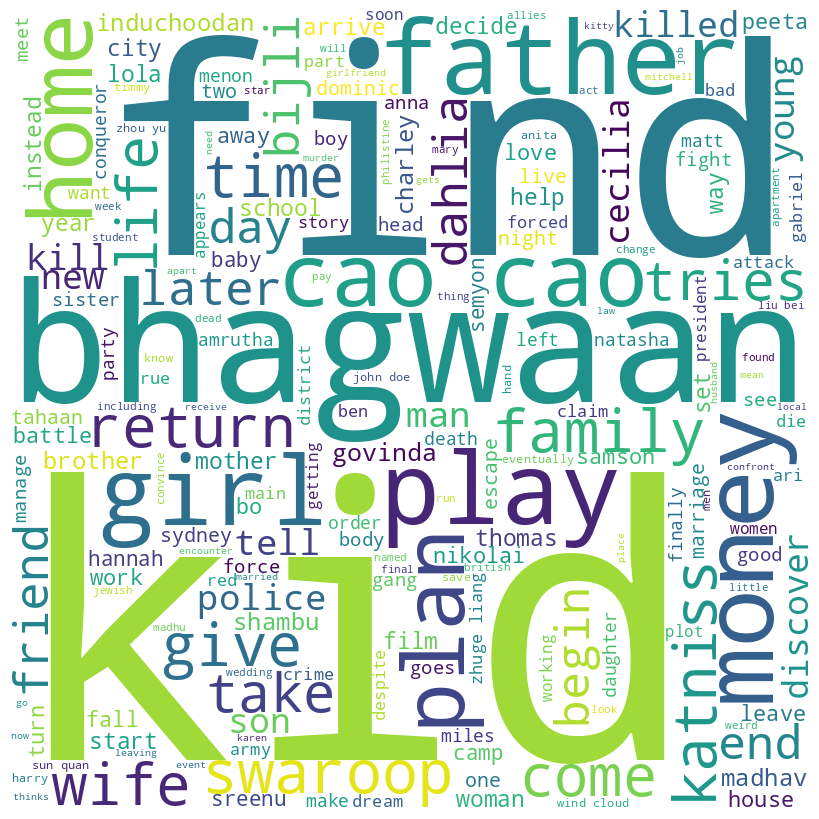

In [8]:
import spacy

# read as dataframe
df_english = pd.read_csv('/content/MovieSummaries/plot_summaries.txt', delimiter = '\t',names=['id','text'])
df_english.info()
df_english = df_english.head(50)

def remove_punctuations(normalized_tokens):
    punctuations=['?',':','!',',','.',';','|','(',')','--','-']
    for word in normalized_tokens:
        if word in punctuations:
            normalized_tokens.remove(word)
    return normalized_tokens

# just keeping pos tagger and lemmatizer
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner',
                                            'tok2vec', 'attribute_ruler'])
lemma_list_spcy = []
for i in range(len(df_english)):
  content = df_english['text'][i]
  doc = nlp(content)
  content_lemma_list = []
  for token in doc:
    content_lemma_list.append(token.lemma_)
  lemma_list_spcy.append(content_lemma_list)

for each_list in lemma_list_spcy:
  for word in each_list:
    lexeme = nlp.vocab[word]
    if lexeme.is_stop == True:
        each_list.remove(word)
  each_list = remove_punctuations(each_list)

# add to data frame
df_english['lemmatizeTextSpcy'] = lemma_list_spcy

# save csv
df_english.head()
df_english.to_csv('englishSpcy.csv')

# generate wordcloud
tokens_string_spcy = ''

for each_list in lemma_list_spcy:
  for word in each_list:
    tokens_string_spcy += word + ' '

wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate(tokens_string_spcy)

# plot the WordCloud image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('wordcloudSPCY.png', dpi=400)

Indexing time complexity:
The first for loop has a time complexity of O(N*M), where N is the number of documents and M is the number of specific token in the documents.
The second for loop has a time complexity of O(M*N), where N is the number of documents and M is the number of specific token in the documents. (cause it iterates over each word in each document and adds it to the set of unique tokens.)
The third for loop has a time complexity of O(M*N), where N is the number of documents and M is the number of specific token in the documents.
Overall, the time complexity is dominated by the second and third for loops, which have a time complexity of O(MN).